# A Python powered Framework for Network Performance Data Analysis-Part 2

## Plotting Geospatial Data 

This part has much less to do with any network counter or a mobile network related KPI, but ***mobile network optimisation cannot be thought seperate form geographical data and related analysis***. 

In my daily work, I encounter several cases, no matter what grouping, aggregation, time range you use, you cannot see a pattern of the problem, but once you look at the problem on the map (on region, city, site, cell level) it is cristal clear. 

This is why when you think of any well-known network planning/optimisation software; it always has a map layer in its heart. 

Ok, enough with chit-chat.. Let's go python...

There are dozens of geography libraries for Python (or some for javascript too), I am not an expert to discuss all, but I can assure you that I made a fair search and most, ***for me*** the most intuitive and useful ones turned to be [geopandas](http://geopandas.org/)  and [folium](http://folium.readthedocs.io/en/latest/)

<ol>
<li><a href="#DataFrameStructure">DataFrame Structure</a></li>
<li><a href="#Geopandas">Geopandas</a>
<li><a href="#Folium">Folium</a>
        <ol>
        <li><a href="#GeoJson">How to Create your own GeoJson File</a></li>
        <li><a href="#RegionLevelMaps">Region Level Maps</a></li>
        <li><a href="#EditGeoJson">Programmatically Modifying GeoJson File</a></li>
        <li><a href="#SiteLevelMaps">Site/Sector/Cell Level Maps with HTML Pop-Up</a></li>
        <li><a href="#SiteLevelHeatMaps">Site/Sector/Cell Level Heat Maps</a></li>
        <li><a href="#SiteLevelHeatMaps">Site/Sector/Cell Level Heat Maps with Time</a></li>         
        </ol>
</ol>


<a id='DataFrameStructure'></a>
### 1. DataFrame Structure

![dataframe](img\dataframe2.jpg)

Note that, we must always (apart from a beatiful feature in folium) aggregate datetime data, because it does not make sense to plot time information on map (apart from a beatiful feature in folium).

> Did I mention there is a beatiful feture in folium to analyse datetime data? 

Ok. so... this time, ***indexes cannot be random objects. Either index or a column that is one-to-one related to index must contain geographical data.*** And what this geographical data will be is determined by our map data.

In this demo lets assume that CATEGORY_1 is some regions from Germany. And let's download [shape file](https://www.esri.com/library/whitepapers/pdfs/shapefile.pdf) from [here](https://www.suche-postleitzahl.org/download_files/public/plz-1stellig.shp.zip).

> Tip: Although there are several tools, in general it is much harder to modify a shapefile content. This means it is always better choice to stick with the names that are in shapefile. 

In this shapefile there are no city or region names. Just ***1-stellig-postleitzahlen*** i.e. 1 digit post codes of regions in Gemrany. Ideally we would prefer names to understand what is going on, but in fact numbers are more convenient, (reason will become more clear soon) so I stick with that. 

Assume we have post codes mapped to region names as follows:


| Ragion Name  | PLZ |
| ------------- | ------------- |
| A | 0 |
| B | 1 |
| C | 2 |
| D | 3 |

So let's query our data from our demo network database. 

> In real life any counter will be starting in cell level or another network component. Higher order aggregations will be done to understand higher order (rnc, mme, city, region, country) We assume that we are directly querying from a ***view*** that already aggregated our KPIs in ***1 digit postcode (region)*** level for Germany. 

In [1]:
from networklib import networkcon 
nw = networkcon.networkcon("database/network.db")
nw.connect()

2018-06-15 00:32:53.273342 - C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\networkcon.py - conected to db...
2018-06-15 00:32:53.273342 - C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\networkcon.py - fetching queries from C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries


In [2]:
data = nw.get_cat(3).reset_index()
data.index.name ="plz"
data

2018-06-15 00:32:54.542209 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_cat.sql


,CATEGORY_1,SUM_COUNTER_1,PERCENTAGE
plz,,,
0,A,204.3820,0.998965
1,B,208.3688,0.998398
2,C,177.1129,0.999090
3,D,171.8613,0.999400


Ok... if you are following closely, you may be thinking "what the?..." and you are right. Pandas will assign a default index if you reset the actual index. A simple trick to assign imaginary 1-digit-post codes to imaginary regions.  And we set the name of the index to "plz" because our shapefile is using that name.

<a id='Geopandas'></a>
### 2. GeoPandas

[This](http://geopandas.org/) link gives all the details of geopandas for interested reader. For us, the only thing we must remember in this part is that ***we are thinking of dataframes with indexes*** as mentioned in part one. 

Lets repeat this one more time, because geopandas (as its name suggests) is an extension of pandas (at least in some sense) so we can keep the same mind set and keep our coding clean, useful, easy and focus on our actual aim of analysis and trouble-shooting.  

Let's read shapefile and plot to see what it is like. 

In [3]:
import geopandas as gpd
import pandas as pd
%matplotlib notebook

> If you have a very clean shapefile that has a one-to-one matching to your data, you an avoid importing pandas, but in our case our shapefile consists of several polygons that has same plz. This will require a bit more tricky merging as we discuss below


Now, lets read the shapefile and as soon as we read it, we have a familiar DataFrame object, with a special geospatial type column (info() will not tell you this, as it does not tell many other things )

> Note that, we are converting plz to number because it comes as string/object from shapefile and after that setting index to "plz". These steps are necessary to make a clean merge to our data frame where we have performance data.

In [5]:
mapdata = gpd.GeoDataFrame.from_file(".\\mapdata\\plz-1stellig.shp")
mapdata.plz = pd.to_numeric(mapdata.plz)
mapdata.set_index("plz", inplace=True)
mapdata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 87 entries, 0 to 9
Data columns (total 1 columns):
geometry    87 non-null object
dtypes: object(1)
memory usage: 1.4+ KB


In [6]:
mapdata.head()

,geometry
plz,
0,"POLYGON ((14.790676 50.8240092, 14.7900741 50...."
0,"POLYGON ((11.439615 51.1993923, 11.4398009 51...."
0,"POLYGON ((11.6879703 51.8557044, 11.688364 51...."
0,"POLYGON ((11.6860239 51.858941, 11.6869167 51...."
0,"POLYGON ((11.6770183 51.8618793, 11.6783936 51..."


*** Ooopps! Our shapefile consists of multiple polygons that has the same number!.*** This is not a deal-breaker, in fact it is a good example of merging as we will duplicate same value to many polygons and they will render a reigon at the end. so...
![dataframe](img\dontpanic.jpg)

And plot the map data...

<IPython.core.display.Javascript object>


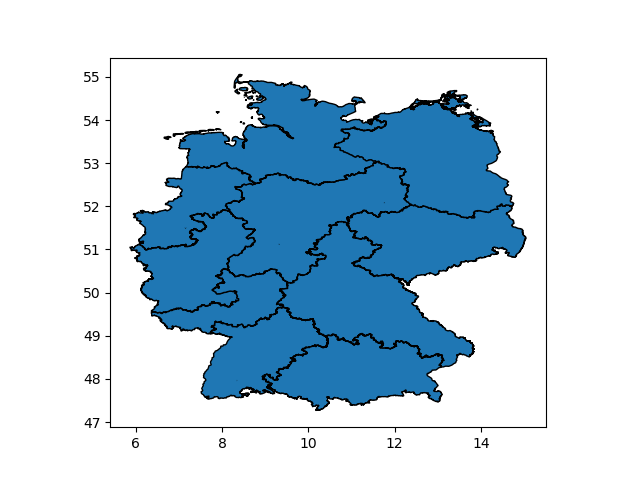

In [8]:
mapdata.plot(edgecolor="black")

For the ones who felt this seems visually improper map of Germany, we can also change projeciton as follows (I won't use this as seeing latitude and longitude in axes feels more intiutive )

<IPython.core.display.Javascript object>


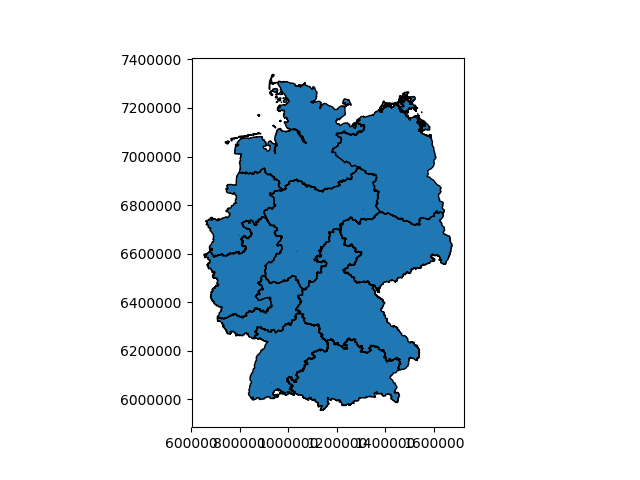

In [9]:
mapdata.to_crs(epsg=3395).plot(edgecolor="black")

So, our map data seems OK, let's merge the data to the map. 

> pd.merge() has several differnet ways of merging. In fact you can merge on any column, but ***as a rule of thumb ı reccomend to work on indexes*** if you don't you are more prone to bugs and things can get out of control very vrey quickly.

Here goes the one-liner

<IPython.core.display.Javascript object>


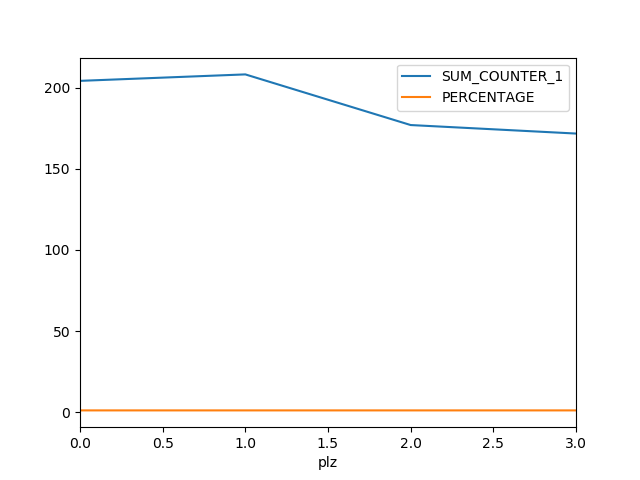

In [13]:
data.merge(mapdata, left_index=True, right_index=True, how='left').plot()

Ups!.. 

what went wrong? 

in fact a lot of things did and will go wrong. Let's tackle them one by one

### Merge, Concatanate, Join order is important

Yes, you must merge to a geo-dataframe (the dataframe that has the geopgraphy column), not the other-way around. (Alhough technically it should still be possible, I could not manage to plot the reverse order, many possible things here, and if you are an expert please do not hesitate to enlighten me.) 

So let's try the other way around and merge our data to our map...

<IPython.core.display.Javascript object>


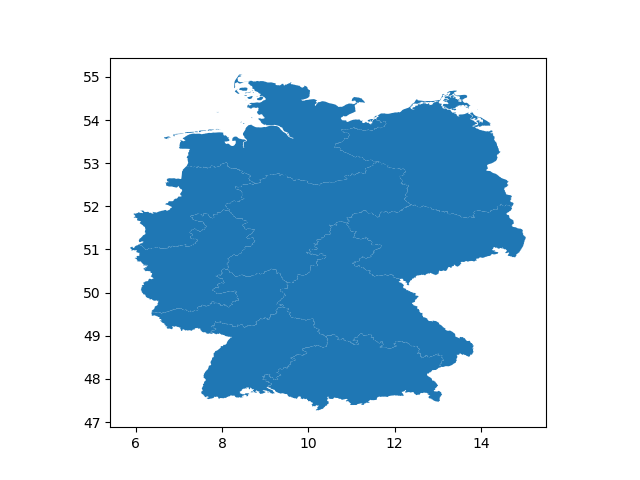

In [14]:
mapdata.merge(data, left_index=True, right_index=True, how='left').plot()

Yes!... 

almost!.. 

geopandas knows that you have a geo-spatial column and clever enough to plot it for us, but if you need information on the map, you need to tell it where.

<IPython.core.display.Javascript object>


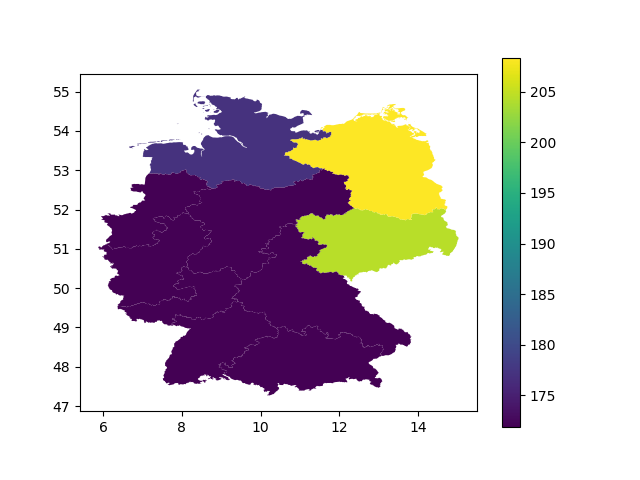

In [15]:
mapdata.merge(data, left_index=True, right_index=True, how='left').plot(column="SUM_COUNTER_1"
                                                                        , legend=True)

Yes!...

almost!...

There is something very very very wrong here. Something your boss will not like if he discovers. Worse than not working code, late delivery, ugly formattting...  


***Working code, but wrong display of data.***

***I cannot stress this enough, when you work with geo-spatila data, there is a risk that you have a polygon that is not matched to anything, and above we see that all unmatched polygons are treated as if they are at the bottom of legend, and are rendered with color.***

***This is wrong and if you work with more complex data you may miss it easily***

Ok.. sorry about the overuse of bold, but it is important. Let's handle missing data. 


<IPython.core.display.Javascript object>


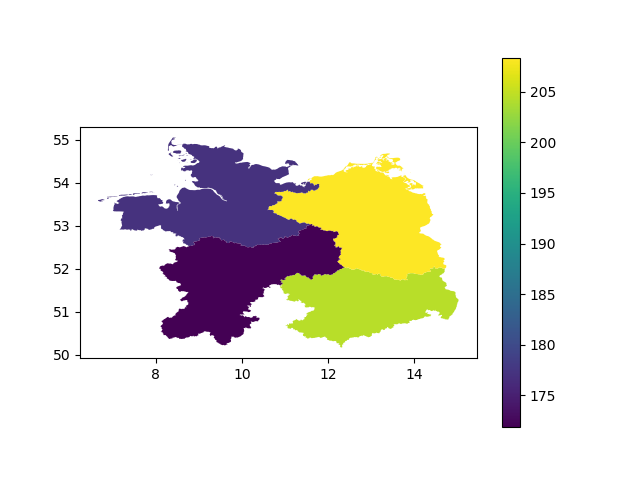

In [16]:
mapdata.merge(data, left_index=True, right_index=True, how='left').dropna().plot(column="SUM_COUNTER_1"
                                                                        , legend=True)

Ok... this is acceptable, as it is correct display. In fact, it may be preferable in some cases as you may want to focus on a detailed region. But, what is we want to see the whole Germany?  

We need 2 layers. (MATLAB nomenclature ON) Hold the axes (MATLAB nomenclature off) and plot second layer over it.

And let's do it with some style...

<IPython.core.display.Javascript object>


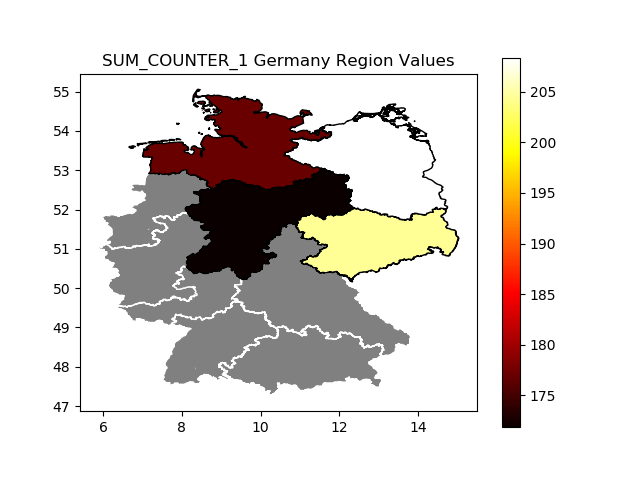

In [17]:
kpi = "SUM_COUNTER_1"
ax = mapdata.merge(data, left_index=True, right_index=True, how='left').plot(color="gray"
                                                                        ,edgecolor="white")

ax.set_title(kpi+ " Germany Region Values")
mapdata.merge(data, left_index=True, right_index=True, how='left').dropna().plot( ax =ax
                                                                        ,column=kpi
                                                                        ,legend=True
                                                                        ,edgecolor="black"
                                                                        ,cmap="hot")

<a id='Folium'></a>
### 3. Folium

Geopandas is a good extension when someone is familiar with pandas. But in network optimizaton one mostly deal with cells, sectors and sites. This means you will deal with several small nodes in a very large area. 


Imagine you could do similar things on an interactive map, where you can dynamically zoom in/out and/or add some pop-ups for additional information. 

This is where [folium](http://folium.readthedocs.io/en/latest/) becomes more handy. 

In fact, in my daily network analysis tasks, if I need a map mostly I work with folium, because it is more flexible and dynamic. As expected it is a bit more complex and we must say good bye to our one-liner plots mostly but results are worth it. 

***Before we switch to python again, I would like to mention a good way of transferring shapefiles to geojson "text" files step by step:***

#### A. How to create your own GeoJson File

1. If you have a shapefile like the one we worked with above and need a geojson go [here](http://mapshaper.org/)

2. Upload all your shapefile documents (*.dbf, *.prj, *.shx, *.shp) 

3. Preferably ***simplfy*** your polygons as much as you want. _This is a very useful option, as number of polygons increase you can optimize your map, because mostly in our work we do not care much about boder/coast detials etc. ***In fact, you can be agressive on simplification because you will have a map layer below every polygon anyway.***_

4. Now you must have a similar screen as this one. just download your *.json file and save it somewhere you know. _in may case "/mapdata/" folder relative to my notebook._

![json](img\json.jpg)

Now we can import folium and json libraries and plot a simple map just to see if [everything is in its right place.](https://www.youtube.com/watch?v=sKZN115n6MI) 

#### B. Region Level Maps

In [18]:
import folium
from folium import plugins
import json

In [19]:
m = folium.Map([51, 10], zoom_start=5)
geo_json_data = json.load(open("mapdata\\plz-1stellig.json", encoding="utf8"))
folium.GeoJson(geo_json_data).add_to(m)
m

In [20]:
data["plz_str"]=data.reset_index().plz.apply(str)
data

,CATEGORY_1,SUM_COUNTER_1,PERCENTAGE,plz_str
plz,,,,
0,A,204.3820,0.998965,0
1,B,208.3688,0.998398,1
2,C,177.1129,0.999090,2
3,D,171.8613,0.999400,3


In [21]:
m = folium.Map([51, 10], zoom_start=5)
m.choropleth( 
    geo_data=geo_json_data,
    data=data,
    columns=['plz_str', "SUM_COUNTER_1"],
    key_on='feature.properties.plz',
    fill_color='YlOrRd',
    line_color='black', line_weight=1,
    fill_opacity=0.6,
    threshold_scale=list(data["SUM_COUNTER_1"].quantile([.05, .25, .5, 0.75, 0.95])),
    legend_name="SUM_COUNTER_1"
)
m

Ok, that was a bit fast forward. Before we make the world a more colorful place, let's focus on ***geo_json_data*** a bit more. It is very crucial to understand what is in it, before we can break down what we did.

So below a little bit "WAX ON.. WAX OFF"

#### C. Programmatically Modifying GeoJson File

In [22]:
type(geo_json_data)

dict

In [23]:
for key, value in geo_json_data.items() :
    print (key)

type
features


In [24]:
type(geo_json_data["features"])

list

This list is infact the list of polygons.

In [25]:
type(geo_json_data["features"][0])

dict

In [26]:
for key, value in geo_json_data["features"][0].items() :
    print (key)

type
geometry
properties


In [27]:
geo_json_data["features"][0]["properties"]

{'highlight': {},
 'plz': '0',
 'style': {'color': 'black',
  'fillColor': '#FD8D3C',
  'fillOpacity': 0.6,
  'opacity': 1,
  'weight': 1}}

Note that, style part of this dictionary is infact modified by the choropleth function above. 

In [28]:
type(geo_json_data["features"][0]["properties"]["plz"])

str

So, deep down in the geojson data, we have plz which is our key to join data and it is ***string***

This is the reason why we create a new column "plz_str" as below

```python
data["plz_str"]=data.reset_index().plz.apply(str)
```

Note also that, we do not set it as index, because folium.choropleth() function requires the column name to join data to polygons as follows


```python
 columns=['plz_str', "SUM_COUNTER_1"]
```

Another thing wihch looks more complicated than it should is 

```python
list(data["SUM_COUNTER_1"].quantile([.05, .25, .5, 0.75, 0.95]))
```

As seen below, this is just a best practice to set legend thresholds in range of the data we want to plot. It is really harder to write thresholds manually, as you will have several different KPIs with several different distributions.

In [29]:
list(data["SUM_COUNTER_1"].quantile([.05, .25, .5, 0.75, 0.95]))

[172.6490399999999,
 175.79999999999993,
 190.74744999999996,
 205.37869999999998,
 207.77078000000003]

Last but not least, If you are reading this document from start, you remember how we freaked out when NAN values were plotted as if they are minimum values in geopandas. I want to repeat the same thing here

There is something very very very wrong here. Something your boss will not like if he discovers. Worse than not working code, late delivery, ugly formattting...  


***Working code, but wrong display of data.***

***I cannot stress this enough, when you work with geo-spatila data, there is a risk that you have a polygon that is not matched to anything, and above we see that all unmatched polygons are treated as if they are at the bottom of legend, and are rendered with color.***

***This is wrong and if you work with more complex data you may miss it easily***

This is where WAX ON, WAX OFF pays off...

***We must overwrite geojson data so that NaN polygons are not there*** This is diffrent than joining and dropping NaNs as in geopandas which was relatively easy. Here we will check the unique plz vlaues with data and remove the rest of the ploygos from geo_json_data. ***Some python magic below***  

```python
temp["features"][:] = [poly for poly in temp["features"] if poly["properties"]["plz"] in list(data[data_key].unique())]
```

This one-liner checks the unique values in the column of data that we will use to join polygons and removes any polygon that is not in this list.  

In [30]:
data_column="SUM_COUNTER_1"
data_key='plz_str'

# copy geo_json_data cos' we will overwrite it
temp = geo_json_data.copy()

# remove polygons of temp that are not matched in data 
temp["features"][:] = [poly for poly in temp["features"] \
                                if poly["properties"]["plz"] in list(data[data_key].unique())]

#re-create clean map
m = folium.Map([51, 10], zoom_start=5, tiles="Mapbox Bright")

m.choropleth(
    geo_data=temp,
    data=data,
    columns=[data_key, data_column],
    key_on='feature.properties.plz',
    fill_color='YlOrRd',
    line_color='black', 
    line_weight=1,
    fill_opacity=0.8,
    threshold_scale=list(data[data_column].quantile([.05, .25, .5, 0.75, 0.95])),
    legend_name=data_column
)
m

#### D. Site/Sector/Cell Level Maps with HTML Pop-Up

Up to here, we just replicated what we did on geopandas. Note how we can move/zoom the map and switch map layer type depending on what we want to observe. This obviously has a big advantage for many practical purposes. 

Note that, everything in part II up to here is infact very general and can be applied to any KPI. Not necessarily network information. But this document is not a geopandas, folium or gis manual, ***it aims to share best practices on network quality analysis/troubleshooting with Python.*** 

And the most "geograpgically" critical element of a mobile nework is a base-station. For the rest of this document I will adress this component as "site". 

> Here I must note that in practice a single latitude, longitude pair will define a lot of co-located sites/sectors/cells in a real network. This is very dependent on the technologies (2G,3G,4G) and/or frequency bands that an operator is giving service on. 

Now assume that we have a dataframe that is aggregated over sites with coordiantes and has some kpi/parameter values per site. 

> I am being a bit lazy here and reading direcly from a csv file consisting of synthetic data, intead of our imaginary network database. 

In [31]:
site = pd.read_csv("site.csv")
site.head()

,site,lat,lon,site_kpi,site_parameter
0,site1,52.309496,13.569882,11,1
1,site2,52.289848,13.301543,9,0
2,site3,52.140101,13.797820,87,0
3,site4,52.312463,13.341013,38,1
4,site5,52.981621,13.746406,15,3


Below is a method to plot all these sites on a map with a radius propotional to the "site_kpi" and adds a neat pop-up for some more information. For ex: you may have a list of sites that have CS Call Drop ratio above some threshold and you want to see if these sties are accumulated somewhere for some reason. 

> ***Warning:*** Since we plot each and every row of some dataframe one by one, this type of method must be used very carefully. From experience, an avarage system will handle 300-500 sites easily most of the time, but nevertheless it should not be overused. 

In [32]:
#re-create clean map
m = folium.Map([52.520007, 13.404954], zoom_start=10, tiles='stamenterrain')

# plot each site one by one as circles 
for index, row in site.iterrows():

    folium.Circle(
        #radius is proportional to kpi
        radius=row.site_kpi*10,
        location=[row.lat, row.lon],
        # a popup for additional information
        popup=" Site Name: " + str(row.site) + \
                " Site KPI: " + str(int(row.site_kpi)) + \
                " Site Parameter: " + str(row.site_parameter),
        color='red',
        fill=True,
        opacity=0.7,
        weight = 1
        ).add_to(m)
m

#### E. Site/Sector/Cell Level Maps with Heat Map

The map above is useful in many cases. But imagine you have to analyse a huge region. If you plot too many sites/cells/sectors like this it will be hard to detect an issue, because everything may overlap and make it hard to read. 

Folium has an heatmap option which diynamically accumulates as you zoom out and automatically highlights accumlated regions of any ibformation you may want to plot in your dataframe. 

> ***Note:*** Heat map is a cool feauture in many ways, but it must be used carefully. The algorithm it uses to combine close by points as one is strict and the picture you will see will vary greatly depending on ypur parameters. So handle with care. 

It also has a weight option for individual coordinates. 

In [46]:
#re-create clean map
m = folium.Map([52.520007, 13.404954], zoom_start=11, tiles='cartodbdark_matter')

# this is optianal, and very dependent on distribution of values 
site["weight"] = site.site_kpi/max(site.site_kpi)
  
site_list = list()

for index, row in site.iterrows():
    latlon = list()
    latlon.append(row.lat)
    latlon.append(row.lon)
    latlon.append(row.weight)
        
    site_list.append(latlon)    
    
hm = plugins.HeatMap(site_list, radius=30, max_val=0.5)

hm.add_to(m)

m


#### E. Site/Sector/Cell Level Maps with Heat Map with time

And finally, if you add one more dimenson to the list we create above, you can play these views sequentially. 

In [49]:
from random import random

In [50]:
#re-create clean map
m = folium.Map([52.520007, 13.404954], zoom_start=11, tiles='cartodbdark_matter')

site["weight"] = site.site_kpi/max(site.site_kpi)
  
frames = list()

for i in range(1,10):
 
    site_list = list()

    for index, row in site.iterrows():
        latlon = list()
        latlon.append(row.lat)
        latlon.append(row.lon)
        latlon.append(row.weight*i)
        
        site_list.append(latlon) 

    frames.append(site_list)
    
hm = plugins.HeatMapWithTime(frames, radius=30, auto_play=True)

hm.add_to(m)

m